The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

The images for camera calibration are stored in the folder called `camera_cal`.  The images in `test_images` are for testing your pipeline on single frames.  If you want to extract more test images from the videos, you can simply use an image writing method like `cv2.imwrite()`, i.e., you can read the video in frame by frame as usual, and for frames you want to save for later you can write to an image file.  

To help the reviewer examine your work, please save examples of the output from each stage of your pipeline in the folder called `output_images`, and include a description in your writeup for the project of what each image shows.    The video called `project_video.mp4` is the video your pipeline should work well on.  

The `challenge_video.mp4` video is an extra (and optional) challenge for you if you want to test your pipeline under somewhat trickier conditions.  The `harder_challenge.mp4` video is another optional challenge and is brutal!

If you're feeling ambitious (again, totally optional though), don't stop there!  We encourage you to go out and take video of your own, calibrate your camera and show us how you would implement this project from scratch!

In [1]:
import numpy as np
import cv2
import os

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

## 1. Camera calibration using the calibration images

In [2]:
# For plotting
#fig, axes = plt.subplots(nrows=1, ncols=len(os.listdir("camera_cal/")))
#fig.subplots_adjust(hspace=0.5)

# Arrays to store object and image points for all images
objpoints = [] # 3D points (on which we want to transform)
imgpoints = [] # 2d chessboard corners

# for the 9x6 chessboard, make a grid of object points
objp = np.zeros((9*6,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2) 

for i,file in enumerate(os.listdir("camera_cal/")):
    img = mpimg.imread("camera_cal/{}".format(file))
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    h,w = gray.shape
    
    # Find the chess board corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6),None)
    
    # If found, add them to the list
    if ret:
        objpoints.append(objp)
        
        # Optional: To increase accuracy, use subpixels
        # search margin of 11 x 11, no zerozone, criteria = ( type, max_iter = 20 , epsilon = 0.001 )
        corners2 = cv2.cornerSubPix(gray, corners, (11,11), (-1,-1), (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 20, 0.001))
        
        imgpoints.append(corners2)
        
        # plot an example
        #img_cor = cv2.drawChessboardCorners(img, (9,6), corners2, ret)
        #axes[i].imshow(img_cor)
        

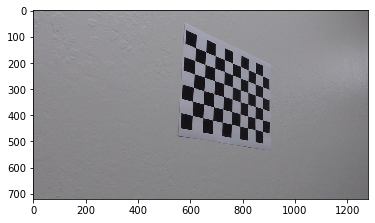

In [3]:
# Compute the camera calibration matrix, distortion coefficients, rotation and translation vectors
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, (w,h), None, None)
undist = cv2.undistort(img, mtx, dist, None, mtx)
plt.imsave("output_images/undist_calibration2.jpg",undist)
plt.imshow(undist)


In [4]:
# A function that thresholds the S-channel of HLS
def hls_select(img, thresh=(0, 255)):
    # Convert to HLS color space
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2]
    
    # Apply a threshold to the S channel
    binary_output = np.zeros_like(s_channel)
    binary_output[(s_channel > thresh[0]) & (s_channel <= thresh[1])] = 1
    
    # Return a binary image of threshold result
    return binary_output

In [5]:
def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    
    # Apply the following steps to img
    # 1) Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # 2) Take the gradient in x and y separately
    abs_sobel_x = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel))
    # 3) Take the absolute value of the x and y gradients
    abs_sobel_y = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel))
    # 4) Use np.arctan2(abs_sobely, abs_sobelx) to calculate the direction of the gradient 
    dir = np.arctan2(abs_sobel_y, abs_sobel_x)
    # 5) Create a binary mask where direction thresholds are met
    binary_output = np.zeros_like(dir)
    binary_output[(dir >= thresh[0]) & (dir <= thresh[1])] = 1
    # 6) Return this mask as your binary_output image
    return binary_output

In [6]:
def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
    
    # Apply the following steps to img
    # 1) Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # 2) Take the gradient in x and y separately 
    sobel_x = cv2.Sobel(gray, cv2.CV_64F, 1, 0,ksize=sobel_kernel)
    sobel_y = cv2.Sobel(gray, cv2.CV_64F, 0, 1,ksize=sobel_kernel)
    # 3) Calculate the magnitude 
    gradmag = np.sqrt(sobel_x**2 + sobel_y**2)
    # 4) Scale to 8-bit (0 - 255) and convert to type = np.uint8
    scaled_sobel = np.uint8(255*gradmag/np.max(gradmag))
    # 5) Create a binary mask where mag thresholds are met
    binary_output = np.zeros_like(scaled_sobel)
    # Here I'm using inclusive (>=, <=) thresholds, but exclusive is ok too
    binary_output[(scaled_sobel >= mag_thresh[0]) & (scaled_sobel <= mag_thresh[1])] = 1
    # 6) Return this mask as your binary_output image
    return binary_output

In [7]:
def abs_sobel_thresh(img, orient='x',sobel_kernel=3, thresh=(0, 255)):
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Apply x or y gradient with the OpenCV Sobel() function
    # and take the absolute value
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel))
    # Rescale back to 8 bit integer
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # Create a copy and apply the threshold
    binary_output = np.zeros_like(scaled_sobel)
    # Here I'm using inclusive (>=, <=) thresholds, but exclusive is ok too
    binary_output[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1

    # Return the result
    return binary_output

In [28]:
def combine_binary_outputs(img):
    """Calculates and combines the binary outputs from different thresholding techniques"""
    # Calculate all the binaries 
    gradx = abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(20, 100))
    grady = abs_sobel_thresh(img, orient='y', sobel_kernel=3, thresh=(20, 100))
    mag_binary = mag_thresh(img, sobel_kernel=7, mag_thresh=(30, 100))
    dir_binary = dir_threshold(img, sobel_kernel=15, thresh=(0.6, 1.5))
    hls_binary = hls_select(img, thresh=(90, 255))

    # Combine all the binaries
    combined = np.zeros_like(dir_binary)
    combined[((gradx == 1) | (grady == 1) | (mag_binary == 1)) & ((dir_binary == 1) | (hls_binary == 1))] = 1

    # axes[i,0].imshow(gradx, cmap='gray')
    # axes[i,0].set_title('gradx')
    # axes[i,1].imshow(grady, cmap='gray')
    # axes[i,1].set_title('grady')
    # axes[i,2].imshow(mag_binary, cmap='gray')
    # axes[i,2].set_title('mag_binary')
    # axes[i,3].imshow(dir_binary, cmap='gray')
    # axes[i,3].set_title('dir_binary')
    # axes[i,4].imshow(hls_binary, cmap='gray')
    # axes[i,4].set_title('hls_binary')
    # axes[i,5].imshow(combined, cmap='gray')
    # axes[i,5].set_title('combined')
    return combined

In [29]:
file = "test3.jpg"

In [30]:

# fig, axes = plt.subplots(len(os.listdir("test_images/")), 6,figsize=(15, 15))

for i,file in enumerate(os.listdir("test_images/")):
    img = mpimg.imread("test_images/{}".format(file))

    # Undistort images
    img = cv2.undistort(img, mtx, dist, None, mtx)

    combined = combine_binary_outputs(img)

    
#plt.savefig("output_images/binary_output.png")

Perspective trasform to top-view

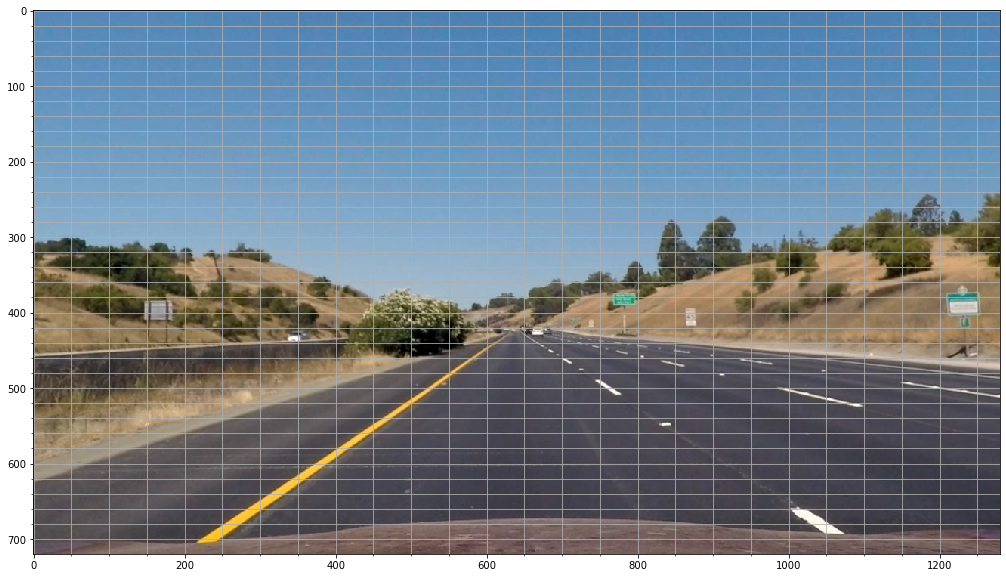

In [9]:
img=mpimg.imread("test_images/straight_lines1.jpg")
img= cv2.undistort(img, mtx, dist, None, mtx)

plt.figure(figsize=(20,10))
plt.imshow(img)
plt.grid(True, 'both')
plt.minorticks_on()

 Look at a straight lines image and determine 4 points to project into top view.
 
 Manual picking of 4 points (720, 200), (460, 575), (460, 700), (720, 1100)
 
 Remember that retar cv2 flips height and width.

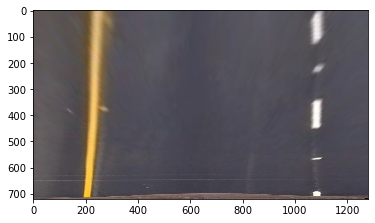

In [17]:
src = np.float32([[200, 720], [575, 460], [700, 460], [1100, 720]])

# define 4 destination points dst = np.float32([[,],[,],[,],[,]])
# LEt's have a margin of 200 in x

dst = np.float32([[200,h],
                  [200,0],
                  [w-200,0],
                  [w-200,h]])
# use cv2.getPerspectiveTransform() to get M, the transform matrix
M = cv2.getPerspectiveTransform(src, dst)
# use cv2.warpPerspective() to warp the image to a top-down view
warped = cv2.warpPerspective(img, M, img.shape[1::-1], flags=cv2.INTER_LINEAR)

plt.imshow(warped)
plt.imsave("output_images/birdeye_straight_lines1.jpg",warped)

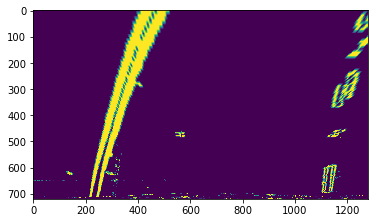

In [41]:
# Warp the binary image into top-down view, using the same parameters as above
binary_warped = cv2.warpPerspective(combined, M, (w,h), flags=cv2.INTER_LINEAR)

plt.imshow(binary_warped)
plt.imsave("output_images/topview_binary_test3.jpg",binary_warped)

### Detect lane pixels and fit a quadratic polynomial

In [44]:
def find_lane_pixels(binary_warped):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and visualize the result
    out_img = np.dstack((binary_warped,binary_warped,binary_warped))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # HYPERPARAMETERS
    # Choose the number of sliding windows
    nwindows = 9
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50

    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),
        (win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),
        (win_xright_high,win_y_high),(0,255,0), 2) 
        
        # Identify the nonzero pixels in x and y within the window #
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    return leftx, lefty, rightx, righty, out_img

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
255.0


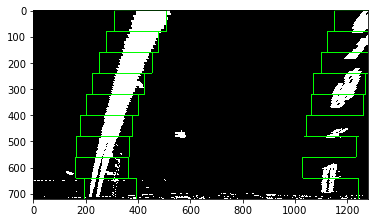

In [45]:
leftx, lefty, rightx, righty, out_img = find_lane_pixels(binary_warped)
print(out_img.max())
plt.imshow(out_img)

In [39]:
def fit_polynomial(binary_warped):
    # Find our lane pixels first
    leftx, lefty, rightx, righty, out_img = find_lane_pixels(binary_warped)

    # Fit a second order polynomial to each using `np.polyfit`
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty

    ## Visualization ##
    # Colors in the left and right lane regions
    out_img[lefty, leftx] = [255, 0, 0]
    out_img[righty, rightx] = [0, 0, 255]

    # Plots the left and right polynomials on the lane lines
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')
    plt.xlim(0, w)
    plt.ylim(h, 0)

    return out_img, left_fit, right_fit

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


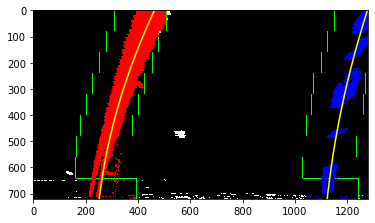

In [46]:
out_img, left_fit, right_fit = fit_polynomial(binary_warped)
plt.imshow(out_img)
plt.imsave("output_images/detectedlanes_test3.jpg",out_img/255)

In [ ]:
def search_around_poly(binary_warped):
    # HYPERPARAMETER
    # Choose the width of the margin around the previous polynomial to search
    margin = 100

    # Grab activated pixels
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    ### Set the area of search based on activated x-values ###
    ### within the +/- margin of our polynomial function ###
    ### Hint: consider the window areas for the similarly named variables ###
    ### in the previous quiz, but change the windows to our new search area ###
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
                    left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
                    left_fit[1]*nonzeroy + left_fit[2] + margin)))
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
                    right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
                    right_fit[1]*nonzeroy + right_fit[2] + margin)))
    
    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    # Fit new polynomials
    left_fitx, right_fitx, ploty = fit_poly(binary_warped.shape, leftx, lefty, rightx, righty)
    
    ## Visualization ##
    # Create an image to draw on and an image to show the selection window
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    window_img = np.zeros_like(out_img)
    # Color in left and right line pixels
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                              ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                              ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    
    # Plot the polynomial lines onto the image
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')
    ## End visualization steps ##
    
    return result

### Calculate the radius of the curvature in real world co-ordinates

Radius of Curvature
The radius of curvature at any point $x$ of the function $x=f(y)$ is given as follows:

$$
\LARGE R_{curve} = \frac{[1 + (\frac{dx}{dy})^2]^{3/2}}{|\frac{d^2x}{dy^2}|}
$$
 
​	 

In the case of the second order polynomial $f(y)=Ay^2+By+C$, the first and second derivatives are:

$$
\large f'(y) = \frac{dx}{dy} = 2Ay+ B
$$

$$
\large f''(y) = \frac{d^2x}{dy^2} = 2Af
$$

So, our equation for radius of curvature becomes:

$$
\LARGE R_{curve} = \frac{(1 + (2Ay + B)^2)^{3/2}}{\left|2A \right|}
$$
​
The $x,y$ are supposed to be in real world coordinates, instead of pixel coordinates. So, we multiply with a scaling factor.

Assuming that the lane is about 30 meters long and 3.7 meters wide, the scaling factor is in vertical direction is 30/height and in horizontal direction is 3.7/width.

In [47]:
y_eval = h # Evaluate curvature at the bottom of the image
ym_per_pix = 30/720 # meters per pixel in y dimension
xm_per_pix = 3.7/700 # meters per pixel in x dimension

left_curverad = ((1 + (2*left_fit[0]*y_eval*ym_per_pix + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
right_curverad = ((1 + (2*right_fit[0]*y_eval*ym_per_pix + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
    

Vehicle position with respect to center:

Assuming the camera is mounted at the center of the car, such that the lane center is the midpoint at the bottom of the image between the two detected lines, the offset of the lane center from the center of the image (converted from pixels to meters) is the distance from the center of the lane to the center of the image.

In [ ]:
camera_center = (left_fit[-1] + right_fit[-1])/2
offset = (w/2 - camera_center)*xm_per_pix